In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import csv
from torch.utils.data import DataLoader ,TensorDataset ,random_split

In [2]:
# Importing Datas From CSV

data = pd.read_csv('../input/titanic/train.csv')

data = data.copy(deep=True)

data.head(7)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S


In [3]:
data['Age'].fillna(np.random.randint(low=30,high=40), inplace=True)

In [4]:
del data['Cabin']
input_cols = ['Pclass','Sex','Age','SibSp','Parch']
# Output col
output_cols = ['Survived']

categorical_cols=list(data.select_dtypes(include=['object']).columns)

In [5]:
pd.isna(data['Age']).head(50)
total_rows = data['Age'].count
#data.head(10)

In [6]:
num_rows = data.shape[0]
num_cols = data.shape[1]

In [7]:
def dataframe_to_array(data):
    
    # copy of the data is created
    dataframe=data.copy(deep=True)
    
    # converting non_numrical datas into codes
    for col in categorical_cols:
        dataframe[col]=dataframe[col].astype('category').cat.codes
        
    # converting input_data to numpy array
    inputs_array = dataframe[input_cols].to_numpy()
    
    # converting output_data to numpy array
    targets_array = dataframe[output_cols].to_numpy()
    
    return inputs_array,targets_array

In [8]:
inputs_array,targets_array = dataframe_to_array(data)

In [9]:
# Converting_Numpy_Array To Tensor

inputs=torch.from_numpy(inputs_array).type(torch.float32)
targets=torch.from_numpy(targets_array).type(torch.float32)

In [10]:
dataset = TensorDataset(inputs,targets)

In [11]:
train_ds,val_ds = random_split(dataset,(791,100))

In [12]:
# Creating DataLoader for both train_ds and val_ds
batch_size = 64

train_loader = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)

val_loader = DataLoader(val_ds,batch_size*2,shuffle=True,num_workers=4,pin_memory=True)

In [13]:
# Creating Deep_Neural_Network
class Neural(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(5,50),
            nn.ReLU(True),
            nn.Linear(50,10),
            nn.ReLU(True),
            nn.Linear(10,1),
            nn.Dropout(0.05)
            
        )
        
    def forward(self,ins):
        out = self.network(ins)
        return out
    def training_step(self,batch):
        inputs,targets=batch
        out=self(inputs)
        loss=F.l1_loss(out,targets)
        return loss
    def validation_step(self,batch):
        inputs,targets=batch
        out=self(inputs)
        loss=F.l1_loss(out,targets)
        return {'val_loss':loss.detach()}
    def validation_epoch(self,output):
        batch_loss=[x['val_loss'] for x in output]
        epoch_loss=torch.stack(batch_loss).mean()
        return {'val_loss':epoch_loss.item()}
    def epoch_end(self,epoch,result,num_epochs):
        # Printing epoch at every 20 steps
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [14]:
model = Neural()
#list(model.parameters())

In [15]:
# Training Model
@torch.no_grad()

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            model.train()
            loss = model.training_step(batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm(model.parameters(),max_norm=1)
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [16]:
result=evaluate(model,val_loader)
result

{'val_loss': 0.9164383411407471}

In [17]:
# Training With Different Learning_Rate
epochs=1
lr=0.0001
weight_decay=0.004
result = fit(epochs, lr,model, train_loader, val_loader)

training_params = [
    (50, 0.0015),
    (50, 0.0014),
    (50, 0.0013),
    (100, 0.0098)
]

for epochs, lr in training_params:
    print(f"Training for {epochs} epochs, with a learning rate of {lr}...")
    result += fit(epochs, lr,model, train_loader, val_loader)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch [1], val_loss: 0.8311
Training for 50 epochs, with a learning rate of 0.0015...
Epoch [20], val_loss: 0.3386
Epoch [40], val_loss: 0.2310
Epoch [50], val_loss: 0.2652
Training for 50 epochs, with a learning rate of 0.0014...
Epoch [20], val_loss: 0.2474
Epoch [40], val_loss: 0.2206
Epoch [50], val_loss: 0.2141
Training for 50 epochs, with a learning rate of 0.0013...
Epoch [20], val_loss: 0.2243
Epoch [40], val_loss: 0.2210
Epoch [50], val_loss: 0.2503
Training for 100 epochs, with a learning rate of 0.0098...
Epoch [20], val_loss: 0.2055
Epoch [40], val_loss: 0.2258
Epoch [60], val_loss: 0.2276
Epoch [80], val_loss: 0.2423
Epoch [100], val_loss: 0.2597


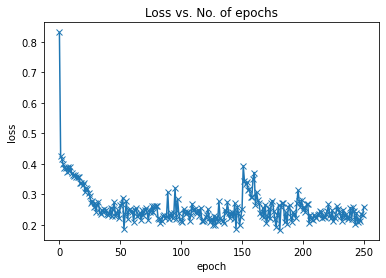

In [18]:
# Epoch Vs Loss
val_loss = result
val_loss_list = [vl['val_loss'] for vl in val_loss]
plt.plot(val_loss_list, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [19]:
# Load each file into a pandas dataframe, this is based on a numpy array
gender_submission = pd.read_csv('../input/titanic/gender_submission.csv',sep=',',parse_dates=False)
test = pd.read_csv('../input/titanic/test.csv',sep=',',parse_dates=False)
test['Age'].fillna(np.random.randint(low=30,high=40), inplace=True)
test = test.copy(deep=True)

# Copying column from gender_sub to test
test['Survived'] = gender_submission['Survived']
inputt,outt = dataframe_to_array(test)
test_in=torch.from_numpy(inputt).type(torch.float32)
test_out=torch.from_numpy(outt).type(torch.float32)
test_dataset = TensorDataset(test_in,test_out)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,1
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,1
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,0


In [20]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)
    
input, target = test_dataset[10]
predict_single(input, target,model)
input, target = test_dataset[1]
predict_single(input, target, model)
input, target = test_dataset[59]
predict_single(input, target, model)
input, target = test_dataset[74]
predict_single(input, target, model)
input, target = test_dataset[45]
predict_single(input, target, model)

Input: tensor([ 3.,  1., 35.,  0.,  0.])
Target: tensor([0.])
Prediction: tensor([0.0663])
Input: tensor([ 3.,  0., 47.,  1.,  0.])
Target: tensor([1.])
Prediction: tensor([1.0048])
Input: tensor([ 1.,  0., 36.,  0.,  0.])
Target: tensor([1.])
Prediction: tensor([1.0048])
Input: tensor([ 1.,  0., 35.,  0.,  0.])
Target: tensor([1.])
Prediction: tensor([1.0048])
Input: tensor([ 3.,  1., 25.,  0.,  0.])
Target: tensor([0.])
Prediction: tensor([0.0296])


In [77]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                
    prediction = predictions[0].detach()
    return prediction

#for i in range (len(test)):
#    input,target = test_dataset[i]
#    p = predict_single(input, target, model)
#    if (p >= 0.9) | (p<=1):
#        titanic['Survived'] = t
Survived = []        
for i in range (len(test)):
    input,target = test_dataset[i]
    p = predict_single(input, target, model)
    Survived.append(p.tolist())

In [96]:
feilds = ['PassengerId','Survived']
with open ('Titanic.csv','w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(feilds)

In [97]:
Titanic=pd.read_csv('./Titanic.csv','w')
Titanic['PassengerId'] = gender_submission['PassengerId']
Titanic.head(5)

,"PassengerId,Survived",PassengerId
0,NaN,892
1,NaN,893
2,NaN,894
3,NaN,895
4,NaN,896


In [100]:
Survived = pd.Series(Survived)
Titanic['Survived']=Survived

In [102]:
Titanic.head(5)

,"PassengerId,Survived",PassengerId,Survived
0,NaN,892,[0.06449216604232788]
1,NaN,893,[1.004828929901123]
2,NaN,894,[0.17270050942897797]
3,NaN,895,[0.036932606250047684]
4,NaN,896,[1.004828929901123]


In [104]:
Titanic.to_csv('Titanic.csv')  

In [ ]:
good= pd.read_csv('./Titanic.csv')
good.head(5)